In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from RobotSim373 import *
from classy import *
from Game import *

Version:  0.0.23
Version  1.0.5
Version:  0.0.23
Version:  0.2.20


# GAME CODE

In [3]:
def initial_state():
    board=Board(4,5)
    for i in range(20):
        board[i]=i
    return board

In [4]:
def show_state(state):
    print(state)

In [5]:
def valid_moves(state,player):
    moves=[]
    for i in range(20):
        if state[i]>0:
            moves.append(i)
    
    return moves
            

In [6]:
def update_state(state, player, move):
    new_state=state
    row,col=state.rc_from_index(move)
    for r in range(row,4):
        for c in range(col,5):
            state[move] = 0
            state[r,c]=0
    
    return new_state

In [7]:
def win_status(state,player):
    if player ==1:
        other_player=2
    else:
        other_player=1
   
    if not valid_moves(state,other_player):
        return 'win'

In [8]:
def human_move(state,player):
    print("Player ",player)
    move=int(input('What move?'))
    return move

In [9]:
def random_move(state,player):
    possible_moves=valid_moves(state,player)
    move=random.choice(possible_moves)
    return move

# Robot

In [10]:
def build(robot):    
    body=Box(robot,
             x=5,
            y=5,
            height=7,
            width=.5,
            name='body')
    
    top=Box(robot,
           x=5,
           y=8.75,
           height=.5,
           width=1.25,
           name='top')
    
    bottom=Box(robot,
              x=5,
              y=1.25,
              height=.5,
              width=1.25,
              name='bottom')
    connect(body,top,'weld')
    connect(body,bottom,'weld')
    
    return robot

# Read State Functions

In [11]:
def get_square(im,row,col):

    
    row_start=205
    row_end=245

    col_start=200
    col_end=240
    
    r1=row_start+(row*45)
    r2=row_end+(row*45)
    
    c1=col_start+(col*45)
    c2=col_end+(col*45)
    
    square=im[r1:r2,c1:c2,:]
    return square

def take_picture(t,robot):
    robot.take_picture('board.jpg')
    return True

def read_state(t,robot):
    im=imread('board.jpg')
    
    images=image.load_images('Data')
    data=image.images_to_vectors(images)
    data=remap_targets(data,new_target_names=['Blank','Piece'])

    C=NaiveBayes()
    C.fit(data.vectors,data.targets)
    
    board=Board(4,5)
    i=0
    for r in range(4):
        for c in range(5):
            i+=1
            square=get_square(im,r,c)
            vector=atleast_2d(square.ravel())
            value=C.predict(vector)[0]
            board[r,c]=value
    
    for i in range(20):
        if board[i]==1:
            board[i]=i
    
    robot.board=board
    
    return True

# Behaviors to Execute a Move

In [12]:
def get_move(t,robot):
    S=LoadTable('player_1_skittles.json')    
    state=robot.board
    
    if state not in S:
        move=random_move(state,player)
    else:
        move=top_choice(S[state])
    
    robot.original_move=move   
    robot.move=move
    return True

def move_to_col(t,robot):
    if robot.IsDone==1:
        return True
    
    robot.message='col'
   
    if robot.move==5 or robot.move==10 or robot.move==15:
        col=0
    elif robot.move==1 or robot.move==6 or robot.move==11 or robot.move==16:
        col=1
    elif robot.move==2 or robot.move==7 or robot.move==12 or robot.move==17:
        col=2
    elif robot.move==3 or robot.move==8 or robot.move==13 or robot.move==18:
        col=3
    elif robot.move==4 or robot.move==9 or robot.move==14 or robot.move==19:
        col=4
    
    robot.tx,robot.ty = 8.5+(col*3),5

    cx = robot['body'].x
    cy = robot['body'].y
    
    F=20
    angle=degrees(arctan2(robot.ty-cy,robot.tx-cx))
    
    robot['body'].F=robot['top'].F=robot['bottom'].F=F
    robot['body'].F_angle=robot['top'].F_angle=robot['bottom'].F_angle=angle
    
    if robot['body'].x == robot.tx:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
        robot['body'].F_angle=robot['top'].F_angle=robot['bottom'].F_angle=0
    
    if robot['body'].x >=robot.tx:
        return True
    
    
def move_to_row(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='move to row'
    
    if robot.move==1 or robot.move==2 or robot.move==3 or robot.move==4:
        row=4
    elif robot.move==5 or robot.move==6 or robot.move==7 or robot.move==8 or robot.move==9:
        row=3
    elif robot.move==10 or robot.move==11 or robot.move==12 or robot.move==13 or robot.move==14:
        row=2
    elif robot.move==15 or robot.move==16 or robot.move==17 or robot.move==18 or robot.move==19:
        row=1
        
    robot.tx,robot.ty = robot.tx, 5+(row*3)

    cx = robot['body'].x
    cy = robot['body'].y
    
    F=2
    angle=degrees(arctan2(robot.ty-cy,robot.tx-cx))
    
    robot['body'].F=robot['top'].F=robot['bottom'].F=F
    robot['top'].F_angle=robot['bottom'].F_angle=robot['body'].F_angle=angle
    
    if robot['body'].y == robot.ty:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
    
    if robot['body'].y >= robot.ty:
        return True

def clear(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='clear'
   
    tx,ty= 27,robot.ty
    
    cx = robot['body'].x
    cy = robot['body'].y
    
    
    F=10
    angle=degrees(arctan2(ty-cy,tx-cx))
    robot['top'].F_angle=robot['bottom'].F_angle=robot['body'].F_angle=angle

    if robot['body'].x >= tx:
        return True
    
    if robot['top'].x > robot['bottom'].x:        
        robot['body'].F=F
        robot['top'].F=F
        robot['bottom'].F=F+7
    elif robot['top'].x < robot['bottom'].x:        
        robot['body'].F=F
        robot['top'].F=F+7
        robot['bottom'].F=F
    elif robot['body'].x==tx:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
    else:
        robot['body'].F=robot['top'].F=robot['body'].F=F
    
def back_up(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='back up'
  
    tx,ty= 23,robot.ty
    
    cx = robot['body'].x
    cy = robot['body'].y
    
    
    F=2
    angle=degrees(arctan2(ty-cy,tx-cx))
    
    robot['top'].F_angle=robot['bottom'].F_angle=robot['body'].F_angle=angle
        
    if robot['body'].x==tx:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
    elif robot['body'].x <= tx:
        return True
    elif robot['top'].x < robot['bottom'].x:        
        robot['bottom'].F=F+5
        robot['top'].F=F
        robot['body'].F=F
    elif robot['top'].x > robot['bottom'].x:        
        robot['bottom'].F=F
        robot['top'].F=F+5
        robot['body'].F=F
    else:
        robot['body'].F=robot['top'].F=robot['bottom'].F=F
def down(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='down'
    
    tx,ty=25,5
    
    cx = robot['body'].x
    cy = robot['body'].y
    
    
    F=20
    angle=degrees(arctan2(ty-cy,tx-cx))
    
    robot['body'].F=robot['top'].F=robot['bottom'].F=F
    robot['top'].F_angle=robot['bottom'].F_angle=robot['body'].F_angle=angle
        
    if robot['body'].x==tx:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
    elif robot['body'].y <= ty:
        return True
    
def return_to_start(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='return to start'
   
    tx,ty=5,5
    
    cx = robot['body'].x
    cy = robot['body'].y
    
    
    F=20
    angle=degrees(arctan2(ty-cy,tx-cx))
    
    robot['body'].F=robot['top'].F=robot['bottom'].F=F
    robot['top'].F_angle=robot['bottom'].F_angle=robot['body'].F_angle=angle
        
    if robot['body'].x==tx:
        robot['body'].F=robot['top'].F=robot['bottom'].F=0
    elif robot['body'].x <= tx:
        return True

def done(t,robot):
    if robot.IsDone==1:
        return True
    robot.message='done'
    robot['body'].F=robot['top'].F=robot['bottom'].F=0
    
    robot.IsDone=0
    if robot.move==5:
        robot.move=10
        return True
    elif robot.move==1 or robot.move==6:
        robot.move=11
        return True
    elif robot.move==2 or robot.move==7:
        robot.move=12
        return True
    elif robot.move==3 or robot.move==8:
        robot.move=13
        return True
    elif robot.move==4 or robot.move==9:
        robot.move=14
        return True
    else:
        robot.IsDone=1
        return True

def stop(t,robot):
    robot.message='stop'

    robot['body'].F=robot['top'].F=robot['bottom'].F=0
    
    return True


In [13]:
state_machine2=StateMachine({'move_to_col':(move_to_col,'move_to_row'),
                           'move_to_row': (move_to_row,'clear'),'clear':(clear,'stop'),'stop':(stop,'back up'),
                            'back up':(back_up,'down'),'down':(down,'return_to_start'),'return_to_start':(return_to_start,'done'),
                            'done':(done,'_end_simulation'),},
                           first_state='move_to_col')


state_machine=StateMachine({'move_to_col':(move_to_col,'move_to_row'),
                           'move_to_row': (move_to_row,'clear'),'clear':(clear,'stop'),'stop':(stop,'back up'),
                            'back up':(back_up,'down'),'down':(down,'return_to_start'),'return_to_start':(return_to_start,'done'),
                            'done':(done,state_machine2),},
                           first_state='move_to_col')

robot_move=StateMachine({'take picture':(take_picture,'read state'),
                            'read state':(read_state,'get move'),
                            'get move':(get_move,state_machine),},
                           first_state='take picture')


# Final Game

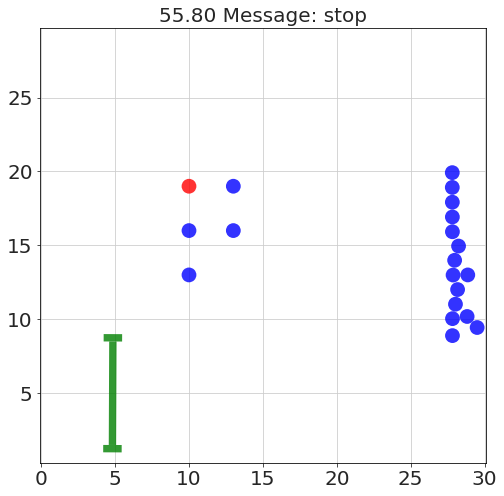

 0  1  0  0  0 
 5  6  0  0  0 
10  0  0  0  0 
 0  0  0  0  0 

Player  2


In [ ]:
env=Environment(width=30,linearDamping=10) 
robot=Robot(env)
build(robot)

for i in range(20):
    if i<=4:
        Disk(env,
             x=(i*3)+10,
            y=10,
            radius=.5)
    elif i<=9:
        Disk(env,
             x=(i*3)-5,
            y=13,
            radius=.5)
    
    elif i<=14:
        Disk(env,
             x=(i*3)-20,
            y=16,
            radius=.5)
    elif i<=19:
        
        if i==15:
            Disk(env,
             x=(i*3)-35,
            y=19,
            radius=.5,
                color='red')
        else:   
            Disk(env,
                 x=(i*3)-35,
                y=19,
                radius=.5)

robot.IsDone=0
while True:

    robot.player=1
    robot.move=None

    robot.controller=Controller(robot,robot_move)
    
    run_sim(env,robot.controller,
            total_time=150,  # seconds
            dt=1/60,
            dt_display=1.5,  # make this larger for a faster display
            figure_width=8,
            plot_orientation=False,
           )
    
    robot.IsDone=0
    state=robot.board
    move=robot.original_move
    player=robot.player
    state=update_state(state,player,move)    
    
    if win_status(state,player)=='win':
        print("Player ",player, "wins.")
        break
    elif win_status(state,player)=='lose':
        print("Player ",player, "loses.")
        break
        
    
    player=2
    show_state(state)
    robot.move=human_move(state,player)

    if robot.move in valid_moves(state,player):
        pass
    else:
        raise ValueError("Bad move!")     


    robot.message='Moving pieces manually'
    robot.controller=Controller(robot,state_machine)
    
    run_sim(env,robot.controller,
            total_time=150,  # seconds
            dt=1/60,
            dt_display=1.5,  # make this larger for a faster display
            figure_width=8,
            plot_orientation=False,
           )    
    robot.IsDone=0
    move=robot.move
    state=update_state(state,player,move)    
    
    if win_status(state,player)=='win':
        print("Player ",player, "wins.")
        break
    elif win_status(state,player)=='lose':
        print("Player ",player, "loses.")
        break